In [1]:
import torch, os, glob, tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tbparse import SummaryReader
from sklearn.decomposition import PCA
plt.style.use("mystyle-bright")
from phasegrok.data_gen import generate_data
from phasegrok.utils import get_loss
from torchmetrics.functional import accuracy
from collections import defaultdict

def load_train_test(experiment, device):
    hparams_file = os.path.join(experiment, "hparams.txt")
    with open(hparams_file, "r") as f:
        hparams = eval(f.read())
    pairs, train_indices, test_indices, _ = generate_data(hparams['p'], seed=1, split_ratio=hparams['split_ratio'],
                                                        ignore_symmetric=False,
                                                        batch_size=hparams['batch_size'],)
    nums = torch.arange(hparams['p'])
    Y = nums + nums.view(-1, 1)
    Y = Y % hparams['m'] if hparams['m'] > 1 else Y
    Y = Y.long().to(device)
    loss_func = get_loss(hparams['loss'])
    out_classes = hparams['m'] if hparams['m'] > 1 else 2 * hparams['p'] - 1

    def step(model, embedding, idx):
            x = embedding[idx]
            pred = model(x)
            target = Y[idx[:, 0], idx[:, 1]]
            if loss_func == torch.nn.functional.mse_loss:
                # pred = pred.softmax(1)
                loss = loss_func(pred, torch.nn.functional.one_hot(
                    target, out_classes).float())
            else:
                loss = loss_func(pred, target)
            acc = accuracy(pred, target)
            return loss, acc.item()
    return train_indices, test_indices, step
def compute_entropy(array, axis=None):
    """Compute the entropy of an array."""
    return -np.sum(array * np.log(array), axis=axis)
    
# log_dir = "/home/kitouni/projects/Grok/grokking-squared/runs/modular-addition59-deep-entropyEdition2"
log_dir = "/data/kitouni/modular-addition59-deep-entropyEdition"
experiment_dir = glob.glob(os.path.join(log_dir, '*'))

In [2]:
experiment_dir =["/home/kitouni/projects/Grok/grokking-squared/runs/modular-addition59-deep/0427-1456"]

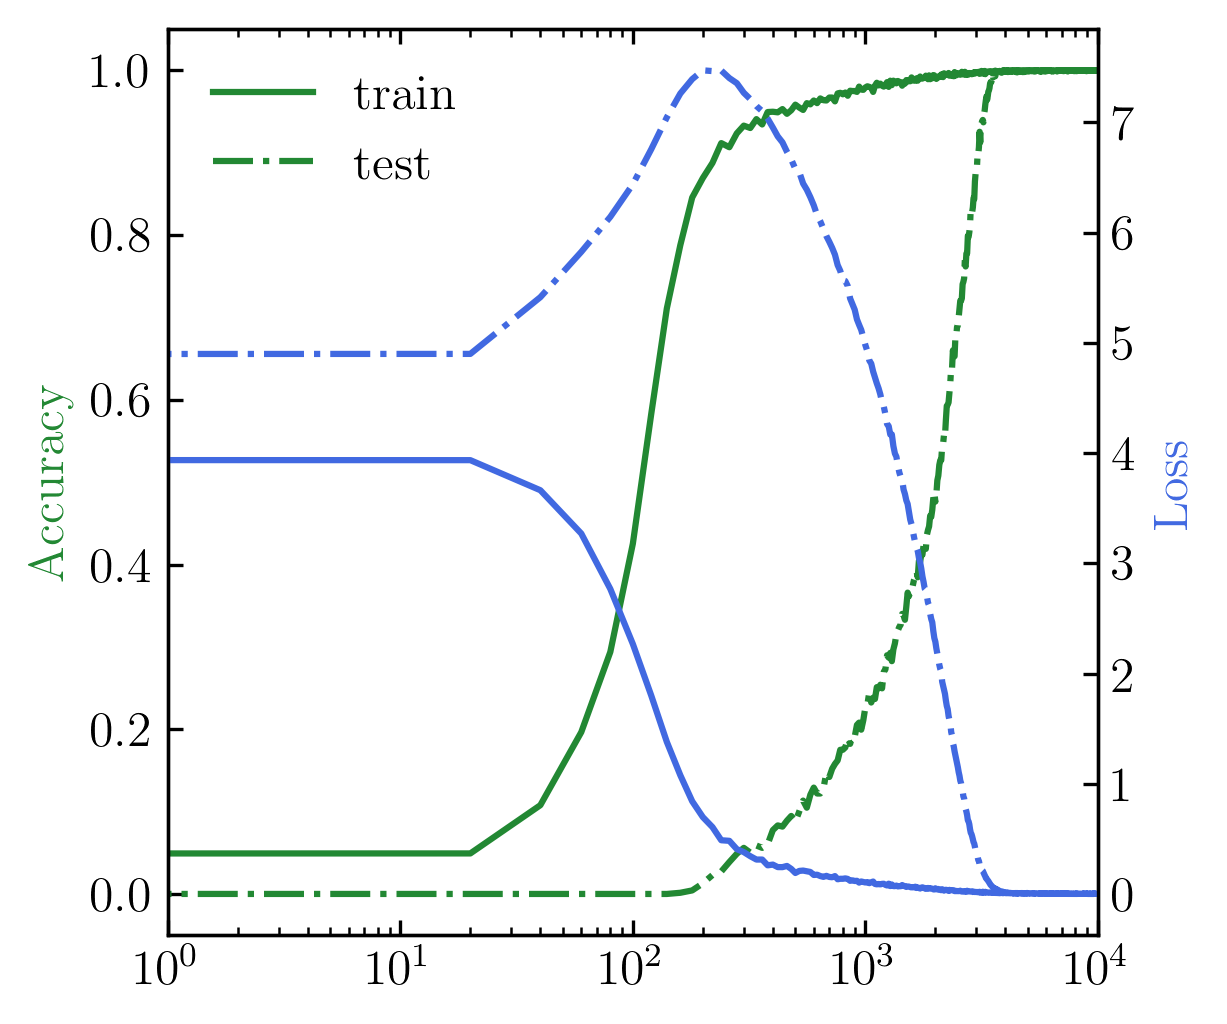

In [3]:
for i, experiment in enumerate(experiment_dir):
    scalars = SummaryReader(experiment, pivot=True).scalars
    loss_train, loss_test, acc_train, acc_test = scalars[
        "loss/train"], scalars["loss/test"], scalars["acc/train"], scalars["acc/test"]
    fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4, 4), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
    ax1 = ax.twinx()
    ax1.plot(scalars.step, loss_train, label="train", c="C0")
    ax1.plot(scalars.step, loss_test, label="test", c="C0", ls="-.")
    ax1.set_ylabel("Loss", color="C0")
    ax.plot(scalars.step, acc_train, label="train", c="C1")
    ax.plot(scalars.step, acc_test, label="test", c="C1", ls="-.")
    ax.set_ylabel("Accuracy", color="C1")
    ax.set_xlim(1, 10000)
    ax.set_xscale("log")
    ax.legend()
    break

In [5]:
accuracies_dict = {}
device = "cuda:0"
train_indices, test_indices, step = load_train_test(experiment, device)
def get_accs(experiment, n_components=10):
    pca = PCA(n_components=n_components)
    accuracies = defaultdict(list)
    embedding_files = glob.glob(os.path.join(experiment, "weights", "*.embd"))
    embedding_files = sorted(embedding_files, key=lambda x: int(x.split("/")[-1].split(".")[0]))
    model_files = glob.glob(os.path.join(experiment, "weights", "*.ckpt"))
    model_files = sorted(model_files, key=lambda x: int(x.split("/")[-1].split(".")[0]))
    model = torch.load(os.path.join(experiment, "model.pt"))
    trange = tqdm.trange(len(embedding_files))
    for i in trange:
        embedding = torch.load(embedding_files[i]).to(device)
        embedding_ = pca.fit_transform(embedding.cpu().numpy())
        embedding_ = torch.tensor(pca.inverse_transform(embedding_)).to(device)
        model.load_state_dict(torch.load(model_files[i]))
        model = model.to(device)
        with torch.no_grad():
            model.train()
            for idx, *_ in train_indices:
                _, acc_train_ = step(model, embedding_, idx.to(device))
                _, acc_train = step(model, embedding, idx.to(device))
            model.eval()
            for idx, *_ in test_indices:
                _, acc_test_ = step(model, embedding_, idx.to(device))
                _, acc_test = step(model, embedding, idx.to(device))

        accuracies['train'].append(acc_train)
        accuracies['test'].append(acc_test)
        accuracies[f'train{n_components}'].append(acc_train_)
        accuracies[f'test{n_components}'].append(acc_test_)
    return accuracies

# make reconstruction plot
for i, experiment in enumerate(experiment_dir):
    if experiment in accuracies_dict.keys():continue
    accuracies_dict[experiment] = get_accs(experiment, n_components=10)

100%|██████████| 1000/1000 [00:26<00:00, 37.50it/s]


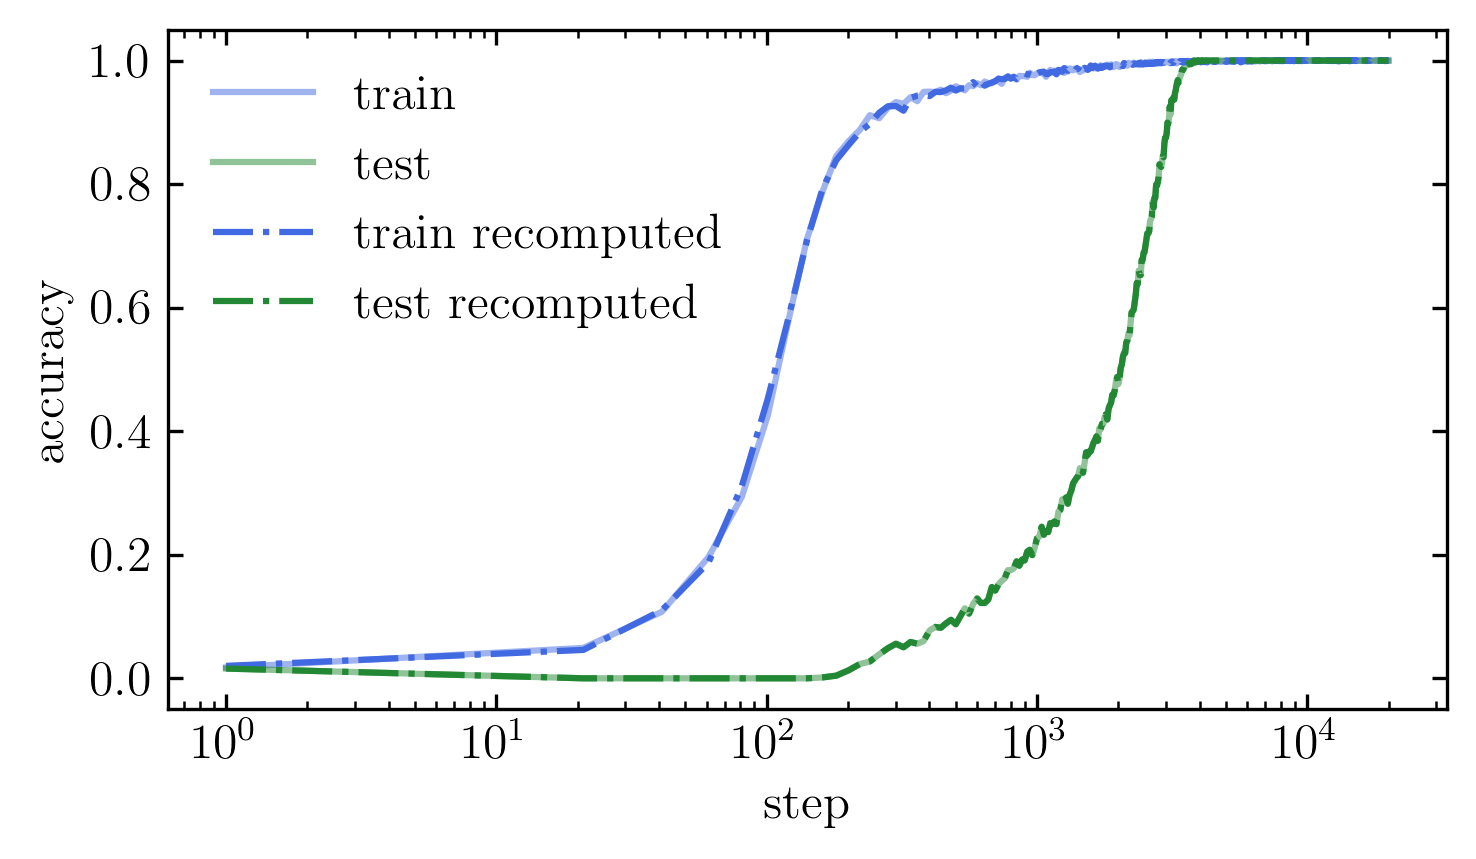

In [6]:
experiment = experiment_dir[0]
scalars = SummaryReader(experiment, pivot=True).scalars
step = scalars.step + 1
acc_train = scalars['acc/train']
acc_test = scalars['acc/test']
acc_train_recomputed = accuracies_dict[experiment]['train']
acc_test_recomputed = accuracies_dict[experiment]['test']
# plot 
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(5.5, 3), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
ax.plot(step, acc_train, label="train", c="C0", alpha=0.5)
ax.plot(step, acc_test, label="test", c="C1", alpha=0.5)
ax.plot(step, acc_train_recomputed, label="train recomputed", c="C0", ls='-.')
ax.plot(step, acc_test_recomputed, label="test recomputed", c="C1", ls="-.")
ax.legend()
ax.set_xlabel("step")
ax.set_ylabel("accuracy")
ax.set_xscale("log")
plt.show()

In [15]:
len(step)

1000

In [16]:
train_indices, test_indices, step = load_train_test(experiment, device)
# pca = PCA(n_components=2)
accuracies = defaultdict(list)
embedding_files = glob.glob(os.path.join(experiment, "weights", "*.embd"))
embedding_files = sorted(embedding_files, key=lambda x: int(x.split("/")[-1].split(".")[0]))
model_files = glob.glob(os.path.join(experiment, "weights", "*.ckpt"))
model_files = sorted(model_files, key=lambda x: int(x.split("/")[-1].split(".")[0]))
model = torch.load(os.path.join(experiment, "model.pt"))
decoder_i = 800
print(model_files[decoder_i])
model.load_state_dict(torch.load(model_files[decoder_i]))
trange = tqdm.trange(len(embedding_files))
for i in trange:
    embedding = torch.load(embedding_files[i]).to(device)
    # embedding_ = pca.fit_transform(embedding.cpu().numpy())
    # embedding_ = torch.tensor(pca.inverse_transform(embedding_)).to(device)
    # model.load_state_dict(torch.load(model_files[i]))
    model = model.to(device)
    with torch.no_grad():
        model.train()
        for idx, *_ in train_indices:
            # _, acc_train_ = step(model, embedding_, idx.to(device))
            _, acc_train = step(model, embedding, idx.to(device))
        model.eval()
        for idx, *_ in test_indices:
            # _, acc_test_ = step(model, embedding_, idx.to(device))
            _, acc_test = step(model, embedding, idx.to(device))
    accuracies['train'].append(acc_train)
    accuracies['test'].append(acc_test)

/data/kitouni/modular-addition59-deep-entropyEdition/0505-040306/weights/16000.ckpt


100%|██████████| 1000/1000 [00:15<00:00, 66.08it/s]


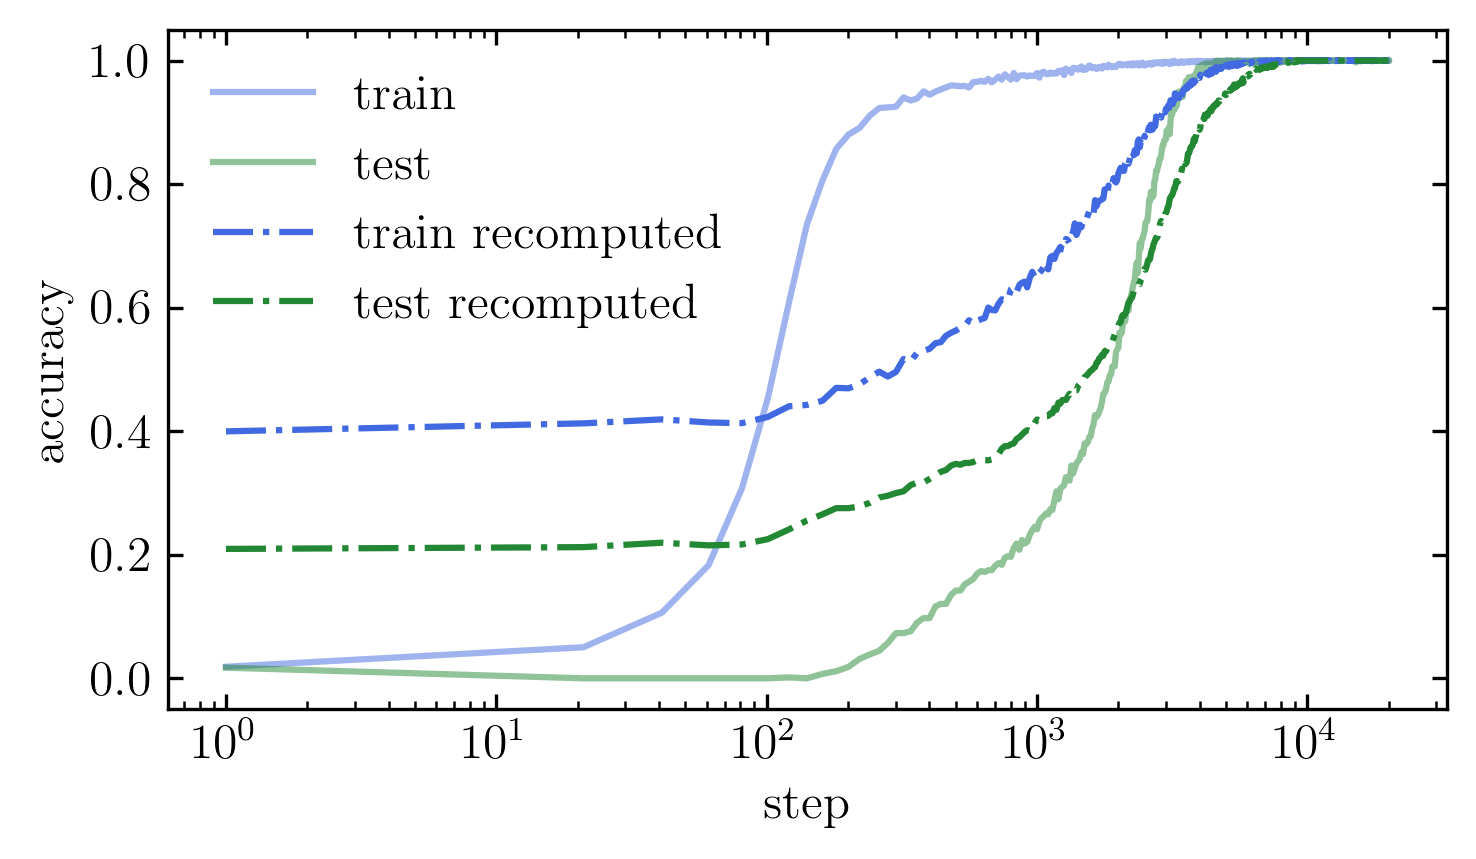

In [19]:
experiment = experiment_dir[0]
scalars = SummaryReader(experiment, pivot=True).scalars
step = scalars.step + 1
acc_train = scalars['acc/train']
acc_test = scalars['acc/test']
acc_train_recomputed = accuracies['train']
acc_test_recomputed = accuracies['test']
# plot 
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(5.5, 3), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
ax.plot(step, acc_train, label="train", c="C0", alpha=0.5)
ax.plot(step, acc_test, label="test", c="C1", alpha=0.5)
ax.plot(step, acc_train_recomputed, label="train recomputed", c="C0", ls='-.')
ax.plot(step, acc_test_recomputed, label="test recomputed", c="C1", ls="-.")
ax.legend()
ax.set_xlabel("step")
ax.set_ylabel("accuracy")
ax.set_xscale("log")
ax.set_title("Accuracy using decoder at step {}".format(step[decoder_i]))
plt.savefig(os.path.join("freeze_plots", f"accuracy_recomputed_{step[decoder_i]}.png"))
plt.show()

# Other experiments

In [12]:
log_dir = "/data/kitouni/modular-addition59-deep-entropyEdition"
experiment_dir = glob.glob(os.path.join(log_dir, '*'))

100%|██████████| 1000/1000 [00:16<00:00, 60.80it/s]


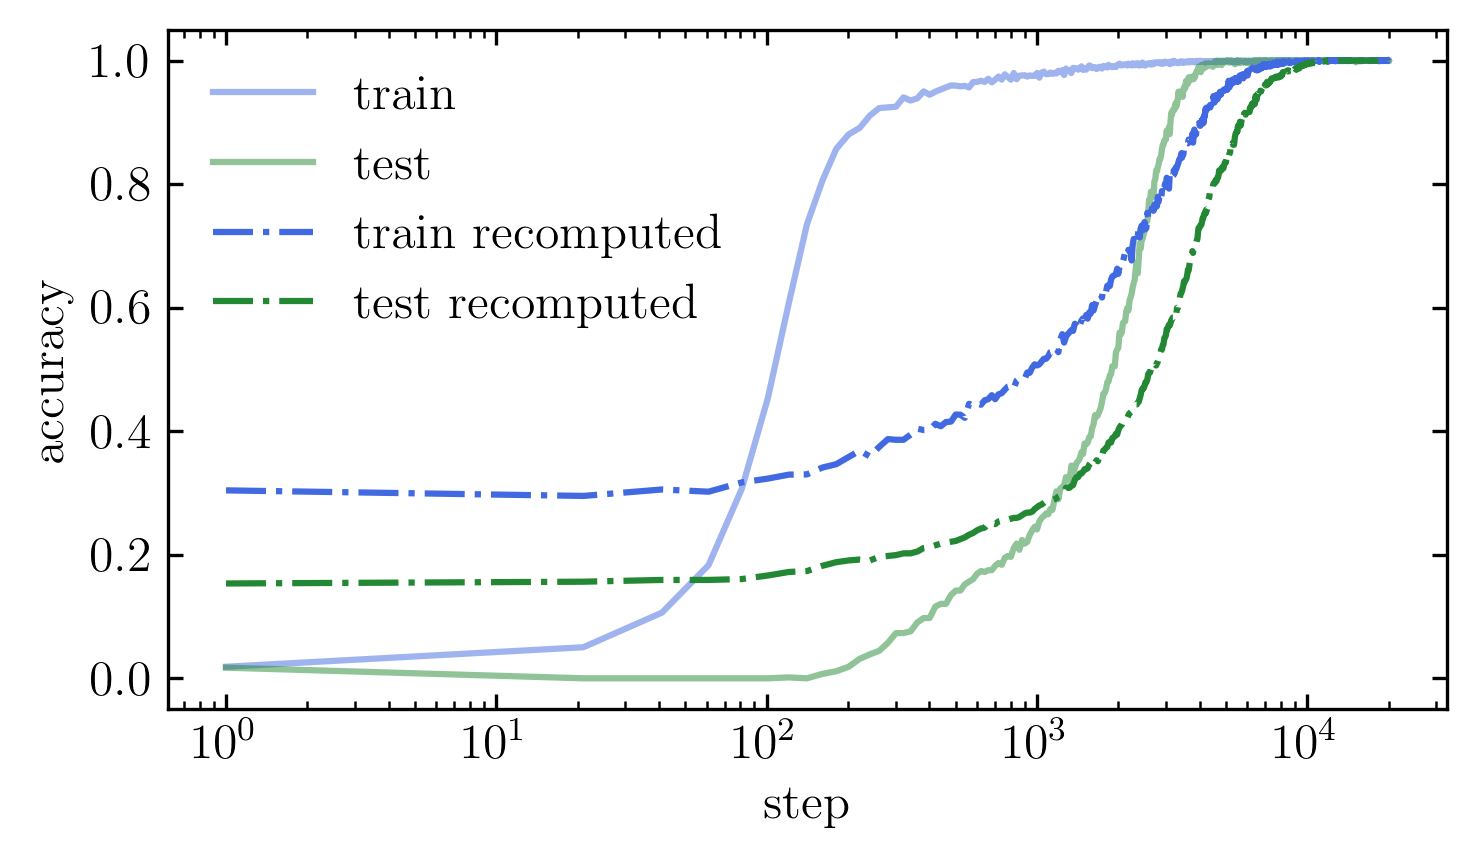

In [14]:
train_indices, test_indices, step = load_train_test(experiment, device)
# pca = PCA(n_components=2)
accuracies = defaultdict(list)
embedding_files = glob.glob(os.path.join(experiment, "weights", "*.embd"))
embedding_files = sorted(embedding_files, key=lambda x: int(x.split("/")[-1].split(".")[0]))
model_files = glob.glob(os.path.join(experiment, "weights", "*.ckpt"))
model_files = sorted(model_files, key=lambda x: int(x.split("/")[-1].split(".")[0]))
model = torch.load(os.path.join(experiment, "model.pt"))
i = -1
model.load_state_dict(torch.load(model_files[i]))
trange = tqdm.trange(len(embedding_files))
for i in trange:
    embedding = torch.load(embedding_files[i]).to(device)
    # embedding_ = pca.fit_transform(embedding.cpu().numpy())
    # embedding_ = torch.tensor(pca.inverse_transform(embedding_)).to(device)
    # model.load_state_dict(torch.load(model_files[i]))
    model = model.to(device)
    with torch.no_grad():
        model.train()
        for idx, *_ in train_indices:
            # _, acc_train_ = step(model, embedding_, idx.to(device))
            _, acc_train = step(model, embedding, idx.to(device))
        model.eval()
        for idx, *_ in test_indices:
            # _, acc_test_ = step(model, embedding_, idx.to(device))
            _, acc_test = step(model, embedding, idx.to(device))
    accuracies['train'].append(acc_train)
    accuracies['test'].append(acc_test)
    
experiment = experiment_dir[0]
scalars = SummaryReader(experiment, pivot=True).scalars
step = scalars.step + 1
acc_train = scalars['acc/train']
acc_test = scalars['acc/test']
acc_train_recomputed = accuracies['train']
acc_test_recomputed = accuracies['test']
# plot 
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(5.5, 3), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
ax.plot(step, acc_train, label="train", c="C0", alpha=0.5)
ax.plot(step, acc_test, label="test", c="C1", alpha=0.5)
ax.plot(step, acc_train_recomputed, label="train recomputed", c="C0", ls='-.')
ax.plot(step, acc_test_recomputed, label="test recomputed", c="C1", ls="-.")
ax.legend()
ax.set_xlabel("step")
ax.set_ylabel("accuracy")
ax.set_xscale("log")
plt.show()

In [11]:
# entropy_list = []
# memorization_step = []
# generalization_step = []
weight_entropy_list = []
norm_list = []
rms_list = []

def normalization(x, axis=-1):
    """Compute normalization values for each sets of scores in x."""
    e_x = np.exp(x)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)


for i, experiment in enumerate(experiment_dir):
    embedding_files = glob.glob(os.path.join(experiment, "weights", "*.embd"))
    embedding_files = sorted(embedding_files, key=lambda x: int(x.split("/")[-1].split(".")[0]))
    if len(embedding_files) != 1000:
        print(f"{experiment} has {len(scalars.step)} steps")
        continue
    scalars = SummaryReader(experiment, pivot=True).scalars
    entropy = []
    norms = []
    rms = []
    for embedding_file in embedding_files:
        embedding = torch.load(embedding_file)
        embedding = embedding.detach().numpy()
        norms.append(np.linalg.norm(embedding, axis=1))
        entropy.append(compute_entropy(normalization(embedding), axis=1))
        rms.append(np.sqrt(np.square(embedding)))
    weight_entropy_list.append(np.array(entropy))
    norm_list.append(np.array(norms))
    rms_list.append(np.array(rms))
    break
    #     pca = PCA()
    #     pca.fit(embedding)
    #     entropy.append(compute_entropy(pca.explained_variance_ratio_))
    # entropy_list.append(entropy)
    # generalization_step.append(scalars.step[scalars['acc/test']>0.99].values[0])
    # memorization_step.append(scalars.step[scalars['acc/train']>0.99].values[0])

In [5]:
# save the entropy and generalization step
# np.save("entropy_list.npy", entropy_list)
# np.save("generalization_step.npy", generalization_step)
# np.save("memorization_step.npy", memorization_step)
# load files
scalars = SummaryReader(experiment_dir[0], pivot=True).scalars
entropy_list = np.load("entropy_list.npy")
generalization_step = np.load("generalization_step.npy")
memorization_step = np.load("memorization_step.npy")

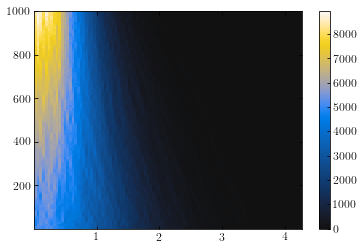

In [110]:
from matplotlib.colors import LogNorm
from colorcet import cm
cmap = cm.CET_CBL2
time = np.repeat(np.arange(1, 1001), (256 * 59))
params = rms_list[0].reshape(-1)
h = plt.hist2d(params, time, bins=100, cmap=cmap)
plt.colorbar(h[3])
plt.show()

Text(0, 0.5, 'embed norm')

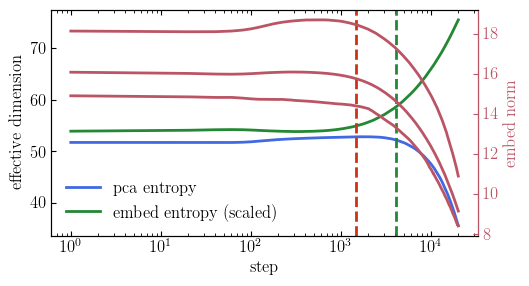

In [113]:
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(5.5, 3), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
ax_norm = ax.twinx()
alpha = 1
lw = 2
ax_norm_color = "C6"
for i, entropy in enumerate(entropy_list):
    entropy = np.exp(entropy)
    weight_entropy = np.exp(weight_entropy_list[i]).mean(-1)
    weight_entropy = weight_entropy / weight_entropy.min() * entropy.max() + 1
    squared_values = rms_list[i]
    rms = squared_values.mean(-1)
    norms = np.array(norm_list[i])
    norms_std = 0 #np.std(norm_list[i], axis=1)
    ax.plot(scalars.step + 1, entropy, c="C0", alpha=alpha, lw=lw, label="pca entropy")
    ax.plot(scalars.step + 1, weight_entropy, c="C1", alpha=alpha, lw=lw, label="embed entropy (scaled)")
    ax_norm.errorbar(scalars.step + 1, norms.mean(1), yerr=norms_std, c=ax_norm_color, alpha=alpha, lw=lw, label="norm")
    ax_norm.plot(scalars.step + 1, norms.max(1), c=ax_norm_color, alpha=alpha, lw=lw, label="norm_max")
    ax_norm.plot(scalars.step + 1, norms.min(1), c=ax_norm_color, alpha=alpha, lw=lw, label="norm_min")
    # ax_norm.plot(scalars.step + 1, squared_values[:, 0].mean(1), c=ax_norm_color, alpha=alpha, lw=lw, label="rms embd")
    # ax_norm.plot(scalars.step + 1, squared_values[:, 0].max(1), c=ax_norm_color, alpha=alpha, lw=lw, label="rms embd max")
    # ax_norm.plot(scalars.step + 1, squared_values[:, 0].min(1), c=ax_norm_color, alpha=alpha, lw=lw, label="rms embd min")
    ax.axvline(generalization_step[i], c="C1", ls="--", alpha=alpha, lw=lw)
    ax.axvline(memorization_step[i], c="C2", ls="--", alpha=alpha, lw=lw)
    break
ax.legend(loc="lower left")
ax.set_xlabel("step")
ax.set_ylabel("effective dimension")
ax.set_xscale("log")

ax_norm.spines['right'].set_color(ax_norm_color)
ax_norm.yaxis.label.set_color(ax_norm_color)
ax_norm.tick_params(axis='y', colors=ax_norm_color)
ax_norm.set_ylabel("embed norm")

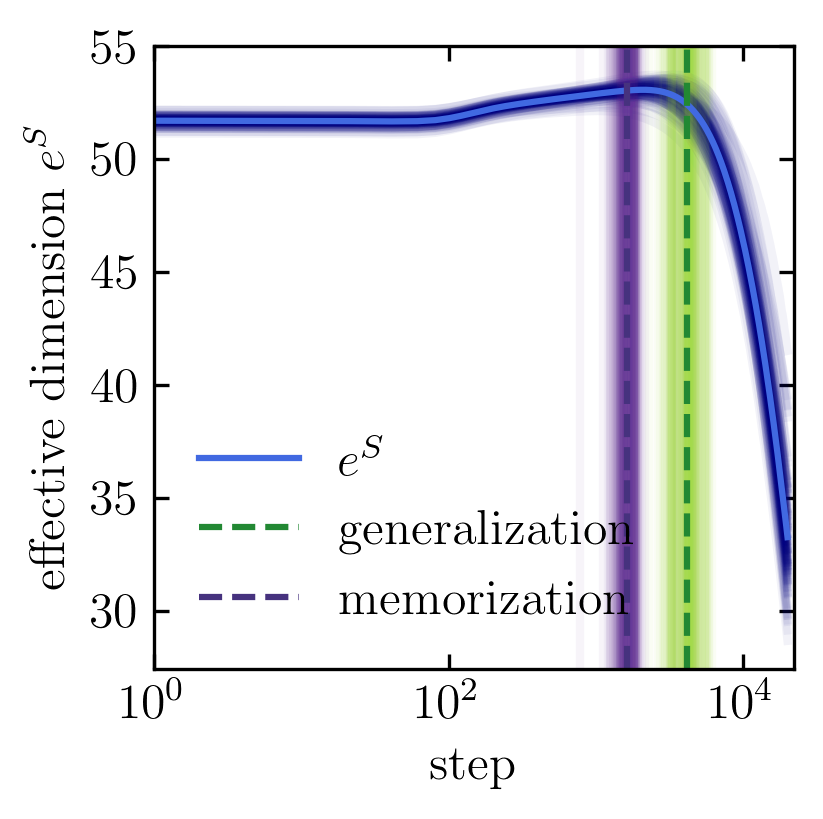

In [20]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(5.5/2, 5.5/2), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

alpha = .05
lw = 0.5
lw = 2
palette = np.array([[160, 218, 57],   # green, compression
                    [253, 231, 37],   # yellow, grokking
                    [70, 50, 126],   # purple, memorization
                    [30,30,30]]) / 255 # black, confusion

for i, entropy in enumerate(entropy_list):
    y = np.exp(entropy)
    ax.plot(scalars.step + 1, y, c='navy', alpha=alpha, lw=lw)
    ax.axvline(generalization_step[i], c=palette[0], ls="-", alpha=alpha, lw=lw)
    ax.axvline(memorization_step[i], c='rebeccapurple', ls="-", alpha=alpha, lw=lw)
# plot means
ax.plot(scalars.step + 1, np.mean(np.exp(entropy_list), axis=0), label="$e^S$", c="C0")
ax.axvline(np.mean(generalization_step), c="C1", ls="--", label="generalization")
ax.axvline(np.mean(memorization_step), c=palette[2], ls="--", label="memorization")
ax.legend()
ax.set_xlim(1, 22000)
ax.set_xlabel("step")
ax.set_ylabel(r"effective dimension $e^S$")
ax.set_xscale("log")
plt.savefig("entropy_vs_step_square.pdf", bbox_inches="tight")


In [25]:
accuracies_dict = {}
device = "cuda:0"
train_indices, test_indices, step = load_train_test(experiment, device)
def get_accs(experiment, n_components=10):
    pca = PCA(n_components=n_components)
    accuracies = defaultdict(list)
    embedding_files = glob.glob(os.path.join(experiment, "weights", "*.embd"))
    embedding_files = sorted(embedding_files, key=lambda x: int(x.split("/")[-1].split(".")[0]))
    model_files = glob.glob(os.path.join(experiment, "weights", "*.ckpt"))
    model_files = sorted(model_files, key=lambda x: int(x.split("/")[-1].split(".")[0]))
    model = torch.load(os.path.join(experiment, "model.pt"))
    trange = tqdm.trange(len(embedding_files))
    for i in trange:
        embedding = torch.load(embedding_files[i]).to(device)
        embedding_ = pca.fit_transform(embedding.cpu().numpy())
        embedding_ = torch.tensor(pca.inverse_transform(embedding_)).to(device)
        model.load_state_dict(torch.load(model_files[i]))
        model = model.to(device)
        with torch.no_grad():
            model.train()
            for idx, *_ in train_indices:
                _, acc_train_ = step(model, embedding_, idx.to(device))
                _, acc_train = step(model, embedding, idx.to(device))
            model.eval()
            for idx, *_ in test_indices:
                _, acc_test_ = step(model, embedding_, idx.to(device))
                _, acc_test = step(model, embedding, idx.to(device))

        accuracies['train'].append(acc_train)
        accuracies['test'].append(acc_test)
        accuracies[f'train{n_components}'].append(acc_train_)
        accuracies[f'test{n_components}'].append(acc_test_)
    return accuracies

In [26]:
# make reconstruction plot
for i, experiment in enumerate(experiment_dir):
    if experiment in accuracies_dict.keys():continue
    accuracies_dict[experiment] = get_accs(experiment, n_components=10)

 26%|██▌       | 256/1000 [00:17<00:51, 14.44it/s]


KeyboardInterrupt: 

In [28]:
# save the accuracies as pandas dataframe pickle
# accuracies_df = pd.DataFrame(accuracies_dict)
# accuracies_df.to_pickle("accuracies_df.pkl")
# load file
accuracies_df = pd.read_pickle("accuracies_df.pkl")
accuracies_dict = accuracies_df.to_dict()

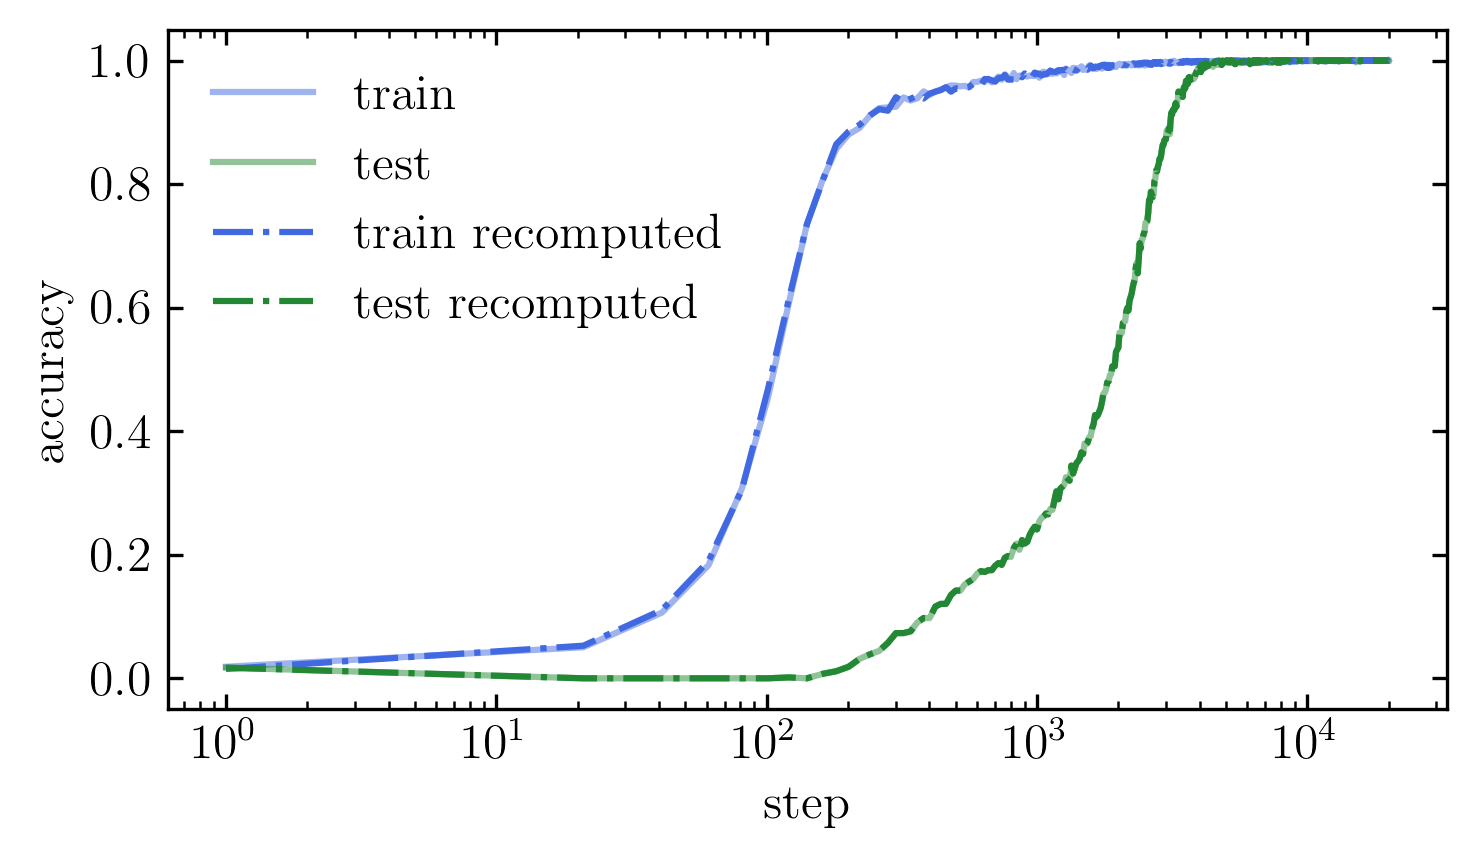

In [47]:
experiment = experiment_dir[0]
scalars = SummaryReader(experiment, pivot=True).scalars
step = scalars.step + 1
acc_train = scalars['acc/train']
acc_test = scalars['acc/test']
acc_train_recomputed = accuracies_dict[experiment]['train']
acc_test_recomputed = accuracies_dict[experiment]['test']
# plot 
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(5.5, 3), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
ax.plot(step, acc_train, label="train", c="C0", alpha=0.5)
ax.plot(step, acc_test, label="test", c="C1", alpha=0.5)
ax.plot(step, acc_train_recomputed, label="train recomputed", c="C0", ls='-.')
ax.plot(step, acc_test_recomputed, label="test recomputed", c="C1", ls="-.")
ax.legend()
ax.set_xlabel("step")
ax.set_ylabel("accuracy")
ax.set_xscale("log")
plt.show()

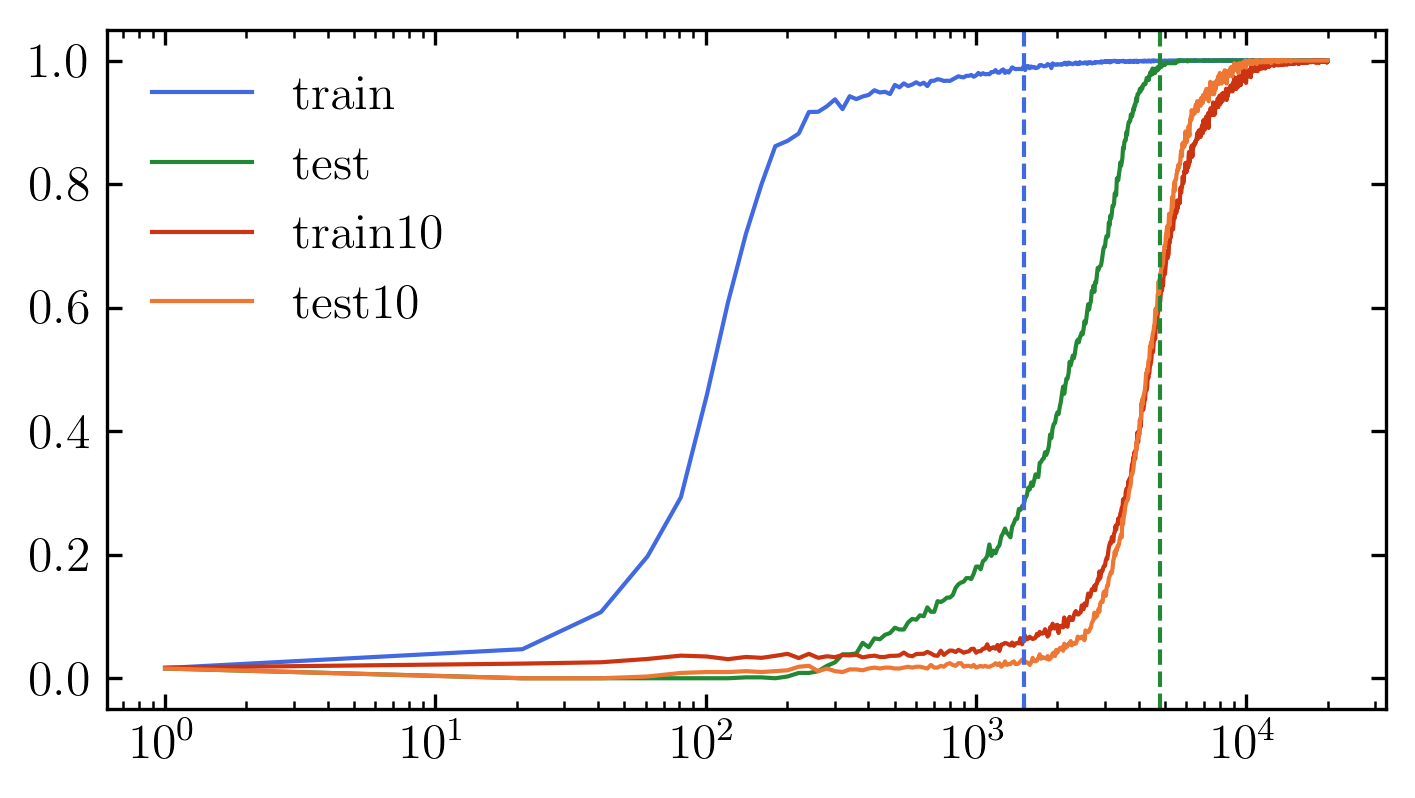

In [53]:
n_components = 10
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(5.5, 3), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
def plot(accuracies, **kwargs):
    y = torch.tensor(accuracies).cpu().numpy()
    plt.plot(scalars.step+1, y, **kwargs)
def line(accuracies, **kwargs):
    y = np.array(accuracies)
    line = scalars.step[(y > 0.99).nonzero()[0][0]]
    plt.axvline(line, **kwargs)

alpha = 1
lw = 1
for i, experiment in enumerate(experiment_dir):
    if i != 6: continue
    accuracies = accuracies_dict[experiment]
    plot(accuracies['train'], alpha=alpha, lw=lw, c="C0", label="train")
    plot(accuracies['test'],  alpha=alpha, lw=lw, c="C1", label="test")
    plot(accuracies[f'train{n_components}'], alpha=alpha, lw=lw, c="C2", label=f"train{n_components}")
    plot(accuracies[f'test{n_components}'], alpha=alpha, lw=lw, c="C3", label=f"test{n_components}")
    # plot generalization and memorization lines|
    line(accuracies['train'], ls="--", c="C0", alpha=alpha, lw=lw)
    line(accuracies['test'], ls="--", c="C1", alpha=alpha, lw=lw)
    break
# plot means
# line(accuracies['train'].mean(), ls="--", c="C0")

plt.legend()
ax.set_xscale("log")
# plt.yscale("logit")
